# Qiskit Workshop: Qiskit Runtime and Primitive Programs

In [27]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np

## Using Qiskit Runtime locally

In [28]:
# If you are running locally, install the qiskit-ibm-runtime package
!pip install qiskit-ibm-runtime -U

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel='ibm_quantum', instance='ibm-q/open/main')

In [32]:
# Save account information if you are running locally

# Uncomment the following line, add your API token, and run this cell.
# service.save_account(channel="ibm_quantum", token="MY_IBM_QUANTUM_TOKEN")

## Service features

In [33]:
# Get available backends

service.backends()

[<IBMBackend('ibm_perth')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibmq_jakarta')>,
 <IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('ibm_lagos')>]

In [6]:
# List available primitive and prototype programs

service.programs()

[<RuntimeProgram('vqc-trainer-XB4wZPrKdv')>,
 <RuntimeProgram('qasm3-runner')>,
 <RuntimeProgram('sampler')>,
 <RuntimeProgram('estimator')>,
 <RuntimeProgram('circuit-runner')>]

In [7]:
print(service.program('sampler'))

sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
  Creation date: 2021-10-26T14:41:57Z
  Update date: 2023-08-19T14:44:09.598959Z
  Max execution time: 10000
  Backend requirements:
    none
  Input parameters:
    Properties:
        - circuit_ids:
            Description: A list of unique IDs of QuantumCircuits.
            Type: array
            Required: False
        - circuit_indices:
            Description: Indices of the circuits to evaluate.
            Type: array
            Required: True
        - circuits:
            Description: A single or list or dictionary of QuantumCircuits.
            Type: ['array', 'object']
            Required: True
        - parameter_values:
            Description: A list of concrete parameters to be bound for each circuit. If specified, it must have the same length as circuit_indices.
            Type: array
            Required: False
        - parameters:
            Description: Param

## Running a Qiskit Runtime program

Example: use the sampler primitive program

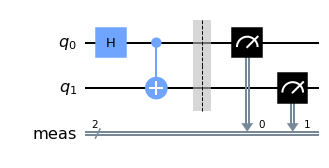

In [8]:
# Create a circuit (Bell state).
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
qc.draw()

In [9]:
# Set the "sampler" program parameters
inputs = {
    'circuit_indices': [0],
    'circuits': qc
}

# Configure backend options
options = {
    'backend': "ibmq_qasm_simulator"
}
    
job = service.run(program_id='sampler', 
                  inputs=inputs,
                  options=options)

In [10]:
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.4755859375, 3: 0.5244140625}], metadata=[{'shots': 1024, 'readout_mitigation_overhead': 1.0, 'readout_mitigation_time': 0.060823815991170704}])


## A better way: Use the `Sampler` class

In [11]:
from qiskit_ibm_runtime import Sampler, Options

backend = service.backend('ibmq_qasm_simulator')
options = Options()
options.execution.shots = 1024

sampler = Sampler(session=backend, options=options)
job = sampler.run(qc)

In [12]:
result = job.result()
print(result)

SamplerResult(quasi_dists=[{0: 0.484375, 3: 0.515625}], metadata=[{'shots': 1024}])


## `Estimator` Primitive

Purpose: compute $\langle\psi| O |\psi\rangle$

where $|\psi\rangle$ is a quantum state, and $O$ is an operator representing an observable.

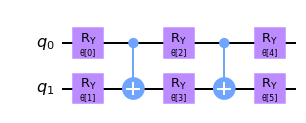

In [13]:
from qiskit.circuit.library import RealAmplitudes

# Create test circuit that has parameterized gates
psi1 = RealAmplitudes(num_qubits=2, reps=2)

psi1.decompose().draw()

In [14]:
# Parameter values for test circuit
theta1 = [0, 1, 1, 2, 3, 5]

In [15]:
from qiskit.quantum_info import SparsePauliOp

# Create observable
H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
print(H1)

SparsePauliOp(['II', 'IZ', 'XI'],
              coeffs=[1.+0.j, 2.+0.j, 3.+0.j])


In [16]:
from qiskit_ibm_runtime import Estimator

options = Options()
options.execution.shots = 1024

# calculate [ <psi1(theta1)|H1|psi1(theta1)> ]
estimator = Estimator(session=backend, options=options)
job = estimator.run(circuits=psi1,
                    observables=H1,
                    parameter_values=[theta1]
                   )
psi1_H1_result = job.result()
print(psi1_H1_result)

EstimatorResult(values=array([1.51757812]), metadata=[{'variance': 9.517467498779297, 'shots': 1024}])


## Example: VQE and `Estimator` in Qiskit Runtime

<img src=https://qiskit.org/documentation/nature/_images/vqe.png width=1000px>

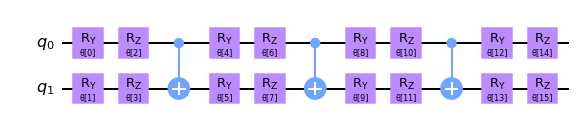

In [17]:
# Create an ansatz circuit to generate the trial ground state
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=H1.num_qubits, entanglement='linear')
ansatz.decompose().draw()

In [18]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [22]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        value = estimator.run(ansatz, hamiltonian, parameter_values=current_vector).result().values[0]
        callback_dict["cost_history"].append(value)
        # Print to screen on single line
        print(
            "Iters. done: {} [value: {}]".format(callback_dict["iters"], value),
            end="\r",
            flush=True
        )

    return callback

In [20]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": []
}

In [23]:
from qiskit_ibm_runtime import Session
from scipy.optimize import minimize

# Randomly initialize the circuit parameters
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    callback = build_callback(ansatz, H1, estimator, callback_dict)
    estimator = Estimator(session=session)
    result = minimize(cost_func, x0,  args=(ansatz, H1, estimator), method="cobyla", options={"maxiter": 50}, callback=callback)
    
print(result)    

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9755000000000003
       x: [ 9.849e-01  1.408e+00 ...  2.945e-01  1.804e+00]
    nfev: 175
   maxcv: 0.0


Text(0, 0.5, 'Cost')

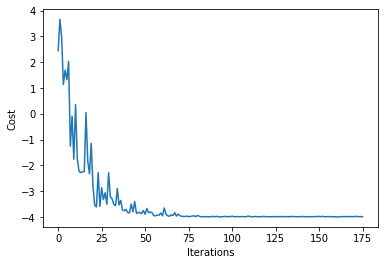

In [25]:
# Plot the expectation value over the iterations of the VQE algorithm
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")

In [26]:
%qiskit_version_table